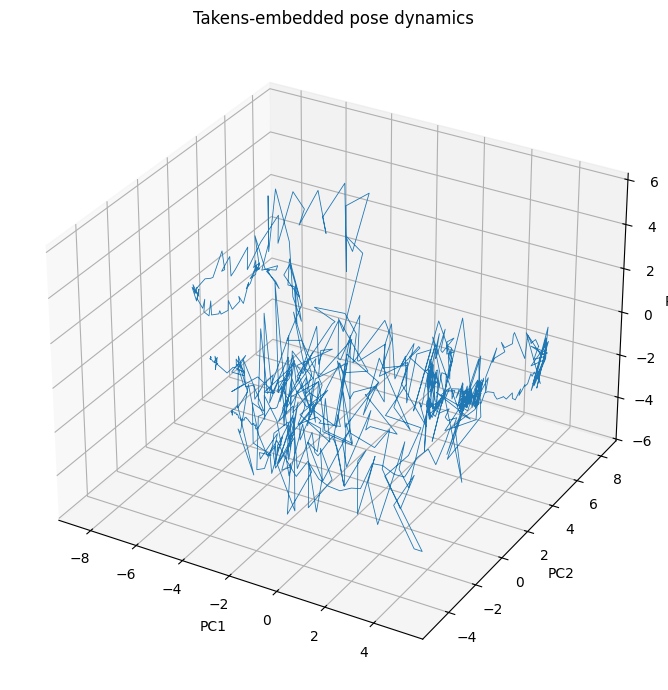

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# =========================
# Takens embedding function
# =========================
def takens_embedding(X, delay=3, dimension=8):
    """
    X: (T, D) time series
    Returns: (T - (m-1)*delay, D*m)
    """
    T, D = X.shape
    max_shift = (dimension - 1) * delay
    if T <= max_shift:
        raise ValueError("Time series too short for chosen delay/dimension")

    return np.hstack([
        X[i * delay : T - max_shift + i * delay]
        for i in range(dimension)
    ])


# =========================
# Load & parse data
# =========================
dat = pd.read_csv(
    "/home/maria/MouseBox/selected_data/models/gpu_working/video_preds/session_view.csv"
)

# Metadata rows
bodyparts = dat.iloc[0, 1:].values
coords    = dat.iloc[1, 1:].values

columns = [f"{bp}_{c}" for bp, c in zip(bodyparts, coords)]

# Numeric pose data
X = dat.iloc[2:, 1:].astype(float)
X.columns = columns
X.reset_index(drop=True, inplace=True)

xy_cols = [c for c in X.columns if c.endswith("_x") or c.endswith("_y")]
X_xy = X[xy_cols].values  # (T, 6)

# =========================
# Reshape & body-center
# =========================
# (T, keypoints=3, xy=2)
X_xy = X_xy.reshape(-1, 3, 2)

# subtract Back keypoint (index 2)
X_centered = X_xy - X_xy[:, [2], :]
X_centered = X_centered.reshape(len(X_centered), -1)  # (T, 6)

# =========================
# Add velocities
# =========================
V = np.diff(X_centered, axis=0, prepend=X_centered[[0]])
X_feat = np.concatenate([X_centered, V], axis=1)  # (T, 12)

# =========================
# Takens embedding
# =========================
tau = 3     # delay (frames)
m   = 8     # embedding dimension

X_takens = takens_embedding(X_feat, delay=tau, dimension=m)

# =========================
# Normalize
# =========================
X_takens = StandardScaler().fit_transform(X_takens)

# =========================
# PCA for visualization
# =========================
Z = PCA(n_components=3).fit_transform(X_takens)

# =========================
# Plot trajectory
# =========================
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")
ax.plot(Z[:, 0], Z[:, 1], Z[:, 2], lw=0.6)
ax.set_title("Takens-embedded pose dynamics")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()
